# Which Teams are Failing to Meet Expectations?

In [135]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from matplotlib import cm
from highlight_text import fig_text, ax_text
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib import cm
import matplotlib.gridspec as gridspec
import numpy as np

from PIL import Image
import urllib
import json
import os

In [136]:
font_path = "../assets/fonts"
for x in os.listdir(font_path):
    for y in os.listdir(f"{font_path}/{x}"):
        if y.split(".")[-1] == "ttf":
            fm.fontManager.addfont(f"{font_path}/{x}/{y}")
            try:
                fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y.split("-")[0])
            except Exception:
                continue

plt.style.use("../assets/stylesheets/soc_base.mplstyle")

## The data

Here we read 538's predictions and compute the expected point tally of each side, using the pre-match probabilities assigned by 538.

In [137]:
df = pd.read_csv('data/10032022.csv', index_col=0).reset_index(drop=True)
df

,season,date,league_id,league,team1,team2,spi1,spi2,prob1,prob2,...,importance1,importance2,score1,score2,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2
0,2022,2022-08-05,1845,German Bundesliga,Eintracht Frankfurt,Bayern Munich,68.47,91.75,0.1350,0.6796,...,32.6,71.9,1.0,6.0,0.83,4.50,0.65,2.72,1.05,5.96
1,2022,2022-08-05,2411,Barclays Premier League,Crystal Palace,Arsenal,71.36,78.53,0.3159,0.4205,...,22.8,48.6,0.0,2.0,1.30,1.36,1.40,2.41,0.00,1.72
2,2022,2022-08-05,1843,French Ligue 1,Lyon,AC Ajaccio,72.03,51.39,0.6941,0.1222,...,50.4,33.5,2.0,1.0,1.82,1.20,0.57,0.69,2.10,0.84
3,2022,2022-08-06,2411,Barclays Premier League,Fulham,Liverpool,58.70,90.51,0.0926,0.7466,...,39.7,68.2,2.0,2.0,1.25,2.57,0.78,1.41,2.10,2.10
4,2022,2022-08-06,1845,German Bundesliga,Borussia Monchengladbach,TSG Hoffenheim,69.38,66.77,0.4872,0.2742,...,40.2,33.3,3.0,1.0,1.86,0.10,2.51,0.31,2.36,1.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,2022,2022-10-02,1854,Italy Serie A,Atalanta,Fiorentina,71.99,67.09,0.5109,0.2267,...,69.9,31.9,1.0,0.0,1.53,0.74,0.95,1.61,1.05,0.00
382,2022,2022-10-02,1869,Spanish Primera Division,Girona FC,Real Sociedad,61.44,73.49,0.3007,0.4148,...,28.4,43.8,3.0,5.0,1.02,2.10,2.02,1.40,3.15,4.88
383,2022,2022-10-02,1843,French Ligue 1,Lens,Lyon,68.35,74.10,0.3827,0.3658,...,61.1,61.4,1.0,0.0,2.96,0.12,1.90,0.07,1.05,0.00
384,2022,2022-10-02,1854,Italy Serie A,Juventus,Bologna,66.72,54.15,0.5484,0.2023,...,27.2,29.3,3.0,0.0,2.28,0.45,1.55,0.25,3.15,0.00


Custom function to compute points across teams.

In [138]:
def compute_points(x,y):
    '''
    This function computed the points achieved by each side.
    '''
    if x > y:
        return 3
    if x == y:
        return 1
    else:
        return 0

In [139]:
df['xpoints1'] = df['prob1']*3 + df['probtie']
df['xpoints2'] = df['prob2']*3 + df['probtie']
df['points1'] = [compute_points(x,y) for x,y in zip(df['score1'], df['score2'])]
df['points2'] = [compute_points(y,x) for x,y in zip(df['score1'], df['score2'])]
df

,season,date,league_id,league,team1,team2,spi1,spi2,prob1,prob2,...,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2,xpoints1,xpoints2,points1,points2
0,2022,2022-08-05,1845,German Bundesliga,Eintracht Frankfurt,Bayern Munich,68.47,91.75,0.1350,0.6796,...,0.83,4.50,0.65,2.72,1.05,5.96,0.5904,2.2242,0,3
1,2022,2022-08-05,2411,Barclays Premier League,Crystal Palace,Arsenal,71.36,78.53,0.3159,0.4205,...,1.30,1.36,1.40,2.41,0.00,1.72,1.2113,1.5251,0,3
2,2022,2022-08-05,1843,French Ligue 1,Lyon,AC Ajaccio,72.03,51.39,0.6941,0.1222,...,1.82,1.20,0.57,0.69,2.10,0.84,2.2660,0.5503,3,0
3,2022,2022-08-06,2411,Barclays Premier League,Fulham,Liverpool,58.70,90.51,0.0926,0.7466,...,1.25,2.57,0.78,1.41,2.10,2.10,0.4385,2.4005,1,1
4,2022,2022-08-06,1845,German Bundesliga,Borussia Monchengladbach,TSG Hoffenheim,69.38,66.77,0.4872,0.2742,...,1.86,0.10,2.51,0.31,2.36,1.05,1.7002,1.0612,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,2022,2022-10-02,1854,Italy Serie A,Atalanta,Fiorentina,71.99,67.09,0.5109,0.2267,...,1.53,0.74,0.95,1.61,1.05,0.00,1.7951,0.9425,3,0
382,2022,2022-10-02,1869,Spanish Primera Division,Girona FC,Real Sociedad,61.44,73.49,0.3007,0.4148,...,1.02,2.10,2.02,1.40,3.15,4.88,1.1866,1.5289,0,3
383,2022,2022-10-02,1843,French Ligue 1,Lens,Lyon,68.35,74.10,0.3827,0.3658,...,2.96,0.12,1.90,0.07,1.05,0.00,1.3996,1.3489,3,0
384,2022,2022-10-02,1854,Italy Serie A,Juventus,Bologna,66.72,54.15,0.5484,0.2023,...,2.28,0.45,1.55,0.25,3.15,0.00,1.8945,0.8562,3,0


In [140]:
df_team1 = df[['team1', 'xpoints1', 'points1']]
df_team2 = df[['team2', 'xpoints2', 'points2']]
df_team1.columns = ['team', 'xpoints', 'points']
df_team2.columns = ['team', 'xpoints', 'points']
df_g = (
    pd.concat([df_team1, df_team2])
    .groupby(['team']).sum()
    .reset_index()
    .assign(difference = lambda x: x.points - x.xpoints)
)
df_g.sort_values(by='difference')

,team,xpoints,points,difference
82,Strasbourg,14.1309,5,-9.1309
15,Bayer Leverkusen,12.4891,5,-7.4891
46,Leicester City,7.9556,1,-6.9556
92,VfL Bochum,7.8406,1,-6.8406
75,Sampdoria,8.7377,2,-6.7377
...,...,...,...,...
8,Arsenal,14.4208,21,6.5792
47,Lens,14.3854,21,6.6146
56,Marseille,15.9386,23,7.0614
88,Udinese,8.1827,16,7.8173


Now we get the twelve teams that have most underperformed their expected points.

In [141]:
df_top_10 = df_g.sort_values(by='difference').head(12).reset_index(drop=True)
df_top_10

,team,xpoints,points,difference
0,Strasbourg,14.1309,5,-9.1309
1,Bayer Leverkusen,12.4891,5,-7.4891
2,Leicester City,7.9556,1,-6.9556
3,VfL Bochum,7.8406,1,-6.8406
4,Sampdoria,8.7377,2,-6.7377
5,AC Ajaccio,10.1399,4,-6.1399
6,Liverpool,16.0278,10,-6.0278
7,Bayern Munich,19.5566,15,-4.5566
8,Internazionale,16.2668,12,-4.2668
9,Elche,5.2654,1,-4.2654


For the logos, we need to do some manual labour and get the team's Fotmob ID.

In [142]:
team_map = {
    'team': [
        'Strasbourg',
        'Bayer Leverkusen',
        'Leicester City',
        'VfL Bochum',
        'Sampdoria',
        'AC Ajaccio',
        'Liverpool',
        'Bayern Munich',
        'Internazionale',
        'Elche',
        'VfB Stuttgart',
        'Wolverhampton'
    ],
    'fotmob_id':[
        9848,
        8178,
        8197,
        9911,
        9882,
        8576,
        8650,
        9823,
        8636,
        10268,
        10269,
        8602
    ],
    'country':[
        'fra',
        'deu',
        'eng',
        'deu',
        'ita',
        'fra',
        'eng',
        'deu',
        'ita',
        'esp',
        'deu',
        'eng'
    ]
}

team_map = pd.DataFrame(team_map)
team_map

,team,fotmob_id,country
0,Strasbourg,9848,fra
1,Bayer Leverkusen,8178,deu
2,Leicester City,8197,eng
3,VfL Bochum,9911,deu
4,Sampdoria,9882,ita
5,AC Ajaccio,8576,fra
6,Liverpool,8650,eng
7,Bayern Munich,9823,deu
8,Internazionale,8636,ita
9,Elche,10268,esp


In [143]:
df_top_10 = pd.merge(df_top_10, team_map)
df_top_10

,team,xpoints,points,difference,fotmob_id,country
0,Strasbourg,14.1309,5,-9.1309,9848,fra
1,Bayer Leverkusen,12.4891,5,-7.4891,8178,deu
2,Leicester City,7.9556,1,-6.9556,8197,eng
3,VfL Bochum,7.8406,1,-6.8406,9911,deu
4,Sampdoria,8.7377,2,-6.7377,9882,ita
5,AC Ajaccio,10.1399,4,-6.1399,8576,fra
6,Liverpool,16.0278,10,-6.0278,8650,eng
7,Bayern Munich,19.5566,15,-4.5566,9823,deu
8,Internazionale,16.2668,12,-4.2668,8636,ita
9,Elche,5.2654,1,-4.2654,10268,esp


Finally, we create a function that takes the timeline of this xPoints and actual points so we can plot a time series.

In [144]:
def get_cumpoints_df(team, data = df):

    df = data.copy()
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    is_in_home = df[(df['team1'] == team)][['team1', 'points1', 'xpoints1', 'date']].reset_index(drop=True)
    is_in_away = df[(df['team2'] == team)][['team2', 'points2', 'xpoints2', 'date']].reset_index(drop=True)
    is_in_home.columns = ['team', 'points', 'xpoints', 'date']
    is_in_away.columns = ['team', 'points', 'xpoints', 'date']
    df = pd.concat([is_in_home, is_in_away]).sort_values(by='date', ascending=True).reset_index(drop=True)
    df['cum_points'] = df['points'].cumsum()
    df['cum_xpoints'] = df['xpoints'].cumsum()
    return df

# Check to see if it works
get_cumpoints_df('Strasbourg')

,team,points,xpoints,date,cum_points,cum_xpoints
0,Strasbourg,0,1.3865,2022-08-06,0,1.3865
1,Strasbourg,1,1.2103,2022-08-14,1,2.5968
2,Strasbourg,1,1.9213,2022-08-21,2,4.5181
3,Strasbourg,0,1.5197,2022-08-27,2,6.0378
4,Strasbourg,1,1.7976,2022-08-31,3,7.8354
5,Strasbourg,1,1.4775,2022-09-04,4,9.3129
6,Strasbourg,1,2.0482,2022-09-11,5,11.3611
7,Strasbourg,0,1.4468,2022-09-17,5,12.8079
8,Strasbourg,0,1.3230,2022-10-01,5,14.1309


## The Visual

In [145]:
def plot_point_difference(ax, team, label_y = False, data=df):
    ax.grid(ls='--', color='lightgrey')
    for spine in ax.spines.values():
        spine.set_edgecolor('lightgrey')
        spine.set_linestyle('dashed')
    ax.tick_params(color='lightgrey', labelsize=8, labelcolor='grey')
    test_df = get_cumpoints_df(team, data)

    ax.plot(test_df.index + 1, test_df['cum_points'], marker='o', mfc='white', ms=5, color='#287271')
    ax.plot(test_df.index + 1, test_df['cum_xpoints'], marker='o', mfc='white', ms=5, color='#D81159')
    ax.yaxis.set_major_locator(ticker.MultipleLocator(3))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
    ax.set_ylim(-1,22)
    ax.set_xlim(0.25)
    ax.set_xticklabels([])
    mid_point = test_df['cum_points'].iloc[-1] + (test_df['cum_xpoints'].iloc[-1] - test_df['cum_points'].iloc[-1])/2
    difference = test_df['cum_points'].iloc[-1] - test_df['cum_xpoints'].iloc[-1]
    text_ = ax.annotate(
        xy=(ax.get_xlim()[1], mid_point),
        text=f'{difference:.1f}',
        xytext=(-5,0),
        ha='center',
        va='center',
        color='#D81159',
        weight='bold',
        size=7,
        textcoords='offset points'
    )
    text_.set_path_effects(
        [path_effects.Stroke(linewidth=1.5, foreground='white'), path_effects.Normal()]
    )
    # ----------------------------------------------------------------
    if label_y:
        ax.set_ylabel('Points', color='grey', size=8)
    else:
        ax.set_yticklabels([])

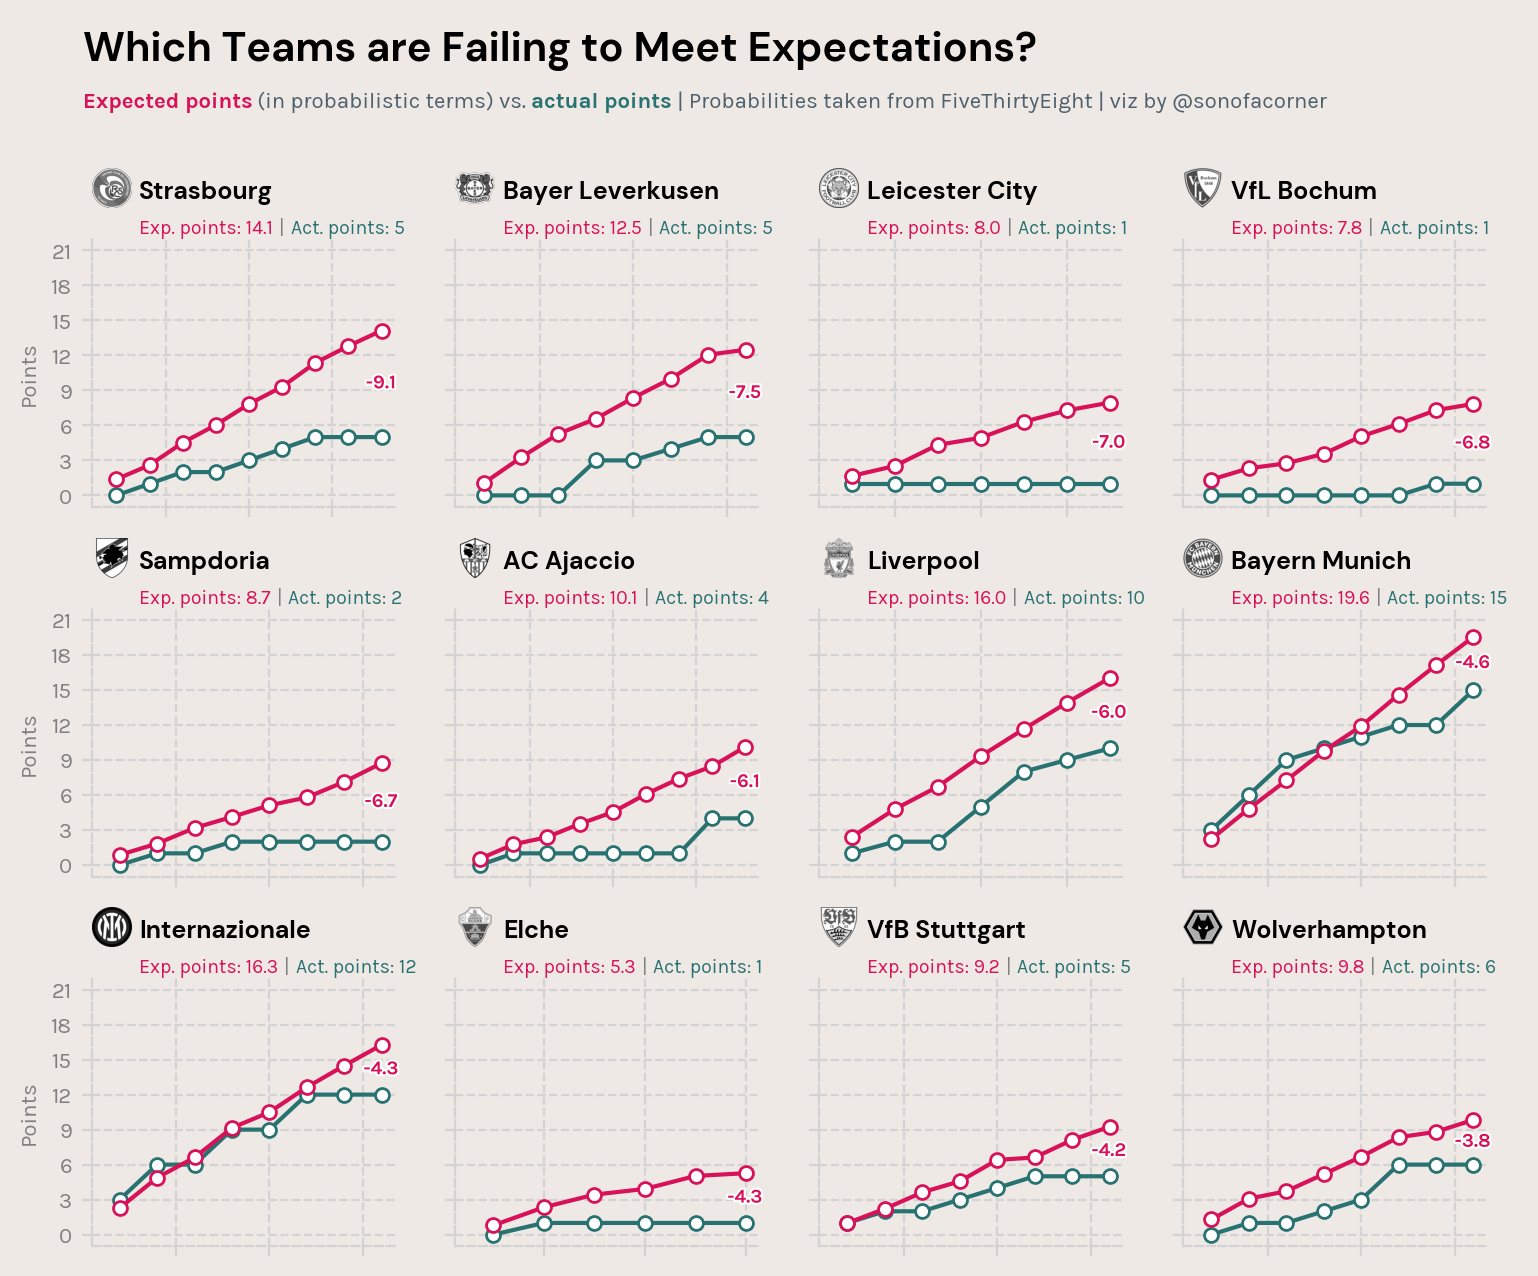

In [146]:
fig = plt.figure(figsize=(9, 7), dpi = 200)
nrows = 6
ncols = 4
gspec = gridspec.GridSpec(
    ncols=ncols, nrows=nrows, figure=fig, 
    height_ratios = [(1/nrows)*2.6 if x % 2 != 0 else (1/nrows)/2.6 for x in range(nrows)], hspace=0.2
)

plot_counter = 0
logo_counter = 0
for row in range(nrows):
    for col in range(ncols):
        if row % 2 != 0:
            ax = plt.subplot(
                gspec[row, col],
                facecolor = "#EFE9E6"
            )
            team = df_top_10['team'].iloc[plot_counter]
            if col == 0:
                label_y = True
            else:
                label_y = False
            
            plot_point_difference(ax, team, label_y)           
            plot_counter += 1
        else:
            teamId = df_top_10['fotmob_id'].iloc[logo_counter]
            teamName = df_top_10['team'].iloc[logo_counter]
            xpoints = df_top_10['xpoints'].iloc[logo_counter]
            apoints = df_top_10['points'].iloc[logo_counter]
            fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
            logo_ax = plt.subplot(
                gspec[row,col],
                anchor = 'NW', facecolor = '#EFE9E6'
            )
            club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{teamId:.0f}.png')).convert('LA')
            logo_ax.imshow(club_icon)
            logo_ax.axis('off')
            # -- Add the team name
            ax_text(
                x = 1.2, 
                y = 0.7,
                s = f'<{teamName}>\n<Exp. points: {xpoints:.1f}> <|> <Act. points: {apoints:.0f}>',
                ax = logo_ax, 
                highlight_textprops=[{'weight':'bold', 'font':'DM Sans'},{'size':'7', 'color': '#D81159'}, {'size':'7', 'color': 'grey'}, {'size':'7', 'color': '#287271'}],
                font = 'Karla', 
                ha = 'left', 
                size = 9, 
                annotationbbox_kw = {'xycoords':'axes fraction'}
            )
            logo_counter += 1

fig_text(
    x=0.12, y=.95, 
    s='Which Teams are Failing to Meet Expectations?',
    va='bottom', ha='left',
    fontsize=15, color='black', font='DM Sans', weight='bold'
)
fig_text(
	x=0.12, y=.92, 
    s='<Expected points> (in probabilistic terms) vs. <actual points> | Probabilities taken from FiveThirtyEight | viz by @sonofacorner',
    highlight_textprops=[{'weight':'bold', 'color': '#D81159'}, {'weight':'bold', 'color': '#287271'}],
	va='bottom', ha='left',
	fontsize=8, color='#4E616C', font='Karla'
)

plt.savefig(
	"figures/10032022_underperformers.png",
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)

plt.savefig(
	"figures/10032022_underperformers_tr.png",
	dpi = 600,
	facecolor = "none",
	bbox_inches="tight",
    edgecolor="none",
	transparent = True
)